# Synthesis Algorithms
- Split Det (sd) = translate to tgba, split, then determinize
- Det Split (ds) = translate to tgba, determinize, then split
- DPA Split (ps) = translate to dpa, then split
- LAR = translate to a deterministic automaton with arbitrar acceptance condition, then use LAR to turn to parity, then split (default)

In [1]:
from dataclasses import dataclass
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json
from glob import glob
import re

# Loading Data

## Synt Tools Loading

In [2]:
RESULTS_PATH = "../assets/synthesis-results"
BENCHMARKS_CSV_PATH = "../assets/benchmarks.csv"

In [3]:
def extract_benchmark_name(benchmark_path):
    return Path(benchmark_path).stem

In [4]:
@dataclass
class BenchmarkResult:
    benchmark_name: str
    tool: str
    total_durations: int # In milliseconds
    is_realizable: bool
    total_states: int
    is_completed: bool
    error: str

    @staticmethod
    def read_from_hoa(hoa_filepath: str):
        hoa = Path(hoa_filepath).read_text()
        
        total_duration_rgx = "Total Duration:\s*(\d+[.]?\d*)"
        tool_name_rgx = "Tool:\s*(.*)[*][/]"
        total_states_rgx = "States:\s*(\d+)"
        benchmark_name = extract_benchmark_name(hoa_filepath)
        
        is_completed = ("REALIZABLE" in hoa) or ("UNREALIZABLE" in hoa)
        error = "\n".join(hoa.split("\n")[2:]) if not is_completed else None
        
        total_duration = float(re.search(total_duration_rgx, hoa).group(1))
        tool_name = re.search(tool_name_rgx, hoa).group(1)
        
        is_realizable = not("UNREALIZABLE" in hoa) if is_completed else None
        total_states = re.search(total_states_rgx, hoa).group(1) if is_realizable else None
    
        return BenchmarkResult(
            benchmark_name, tool_name.strip(), total_duration,
            is_realizable, total_states, is_completed, error
        )

In [5]:
algorithms_output_path = glob(RESULTS_PATH + "/*")
algorithms = [ Path(path).stem for path in algorithms_output_path]

In [6]:
algorithms_benchmarks = {}
for algo, outputs_path in zip(algorithms, algorithms_output_path):
    benchmarks_path = glob(f"{outputs_path}/*")
    benchmarks = [ BenchmarkResult.read_from_hoa(benchmark) for benchmark in benchmarks_path]
    algorithms_benchmarks[algo] = benchmarks

In [7]:
all_benchmarks_dict = []
for algo, benchmarks in algorithms_benchmarks.items():
    for benchmark in benchmarks:
        all_benchmarks_dict.append(benchmark.__dict__)
benchmarks_df = pd.DataFrame(all_benchmarks_dict)
# Removing total duration from incompleted benchmarks
benchmarks_df.loc[benchmarks_df["is_completed"] == False, "total_durations"] = None
benchmarks_df.head()

,benchmark_name,tool,total_durations,is_realizable,total_states,is_completed,error
0,TwoCountersInRangeA4,bfss-synt,292.662,False,None,True,None
1,ltl2dba05,bfss-synt,59.119,True,12,True,None
2,ltl2dba11,bfss-synt,18.899,True,4,True,None
3,TwoCountersDisButA6,bfss-synt,11004.737,False,None,True,None
4,TorcsSteeringSimple,bfss-synt,48.283,True,1,True,None


In [8]:
tools_list = benchmarks_df["tool"].unique()
print("Tool list: ", tools_list)

Tool list:  ['bfss-synt' 'ltlsynt-ds' 'ltlsynt-sd' 'ltlsynt-lar' 'bfss-synt-skip-deps'
 'ltlsynt-ps']


## Dependents Loading

In [9]:
def process_deps_output(deps_output):
    dependent_vars = [
        tested_var["name"]
        for tested_var in deps_output["tested_variables"]
        if tested_var["is_dependent"]
    ]
    
    return {
        'dependent_vars': dependent_vars,
        'dependency_ratio': len(dependent_vars) / len(deps_output['output_vars'])
    }

def extract_deps_from_hoa_file(hoa_filepath: str):
    benchmark_name = extract_benchmark_name(hoa_filepath)
    hoa = Path(hoa_filepath).read_text()
    deps_output = re.search("[/][*]\s*Synthesis Measures:\s*\n(.*)\n[*][/]", hoa)
    
    if deps_output is None:
        return {
            'benchmark_name': benchmark_name
        }
    
    deps_output = json.loads(deps_output.group(1))
    
    return {
        'benchmark_name': benchmark_name,
        **process_deps_output(deps_output)
    }

In [10]:
bfss_output_path = glob("../assets/synthesis-results/bfss-synt/*")
dependents_df = pd.DataFrame([extract_deps_from_hoa_file(bfss_output) for bfss_output in bfss_output_path])
dependents_df.head(3)

,benchmark_name,dependent_vars,dependency_ratio
0,TwoCountersInRangeA4,"[u0first2counter0first2counter, u0second2count...",0.375
1,ltl2dba05,[],0.000
2,ltl2dba11,[],0.000


## Sanity Check

All benchmarks realizabliity are same in all synthesis tools

In [11]:
benchs_by_tool = benchmarks_df.pivot(index="benchmark_name", columns="tool", values=["is_realizable", "is_completed"]).copy()
benchs_by_tool["is_different"] = benchs_by_tool["is_realizable"].apply(lambda x: x.nunique() > 1, axis=1)
benchs_by_tool[benchs_by_tool["is_different"] == True]

Empty DataFrame
Columns: [(is_realizable, bfss-synt), (is_realizable, bfss-synt-skip-deps), (is_realizable, ltlsynt-ds), (is_realizable, ltlsynt-lar), (is_realizable, ltlsynt-ps), (is_realizable, ltlsynt-sd), (is_completed, bfss-synt), (is_completed, bfss-synt-skip-deps), (is_completed, ltlsynt-ds), (is_completed, ltlsynt-lar), (is_completed, ltlsynt-ps), (is_completed, ltlsynt-sd), (is_different, )]
Index: []

## Result Summary

In [12]:
pivoted_benchmarks_df = benchmarks_df.pivot(
    index="benchmark_name",
    columns="tool",
    values=["total_durations","is_realizable","total_states","is_completed"]
)
pivoted_benchmarks_df.head(3)

total_durations                                             \
tool                 bfss-synt bfss-synt-skip-deps ltlsynt-ds ltlsynt-lar   
benchmark_name                                                              
01                      28.062              41.185     41.985      45.017   
02                     158.667             154.814    182.685     195.205   
03                    6914.111            4808.273  26902.344   61097.445   

                                     is_realizable                      \
tool           ltlsynt-ps ltlsynt-sd     bfss-synt bfss-synt-skip-deps   
benchmark_name                                                           
01                  30.46    572.161          True                True   
02                195.194        NaN          True                True   
03                60944.6        NaN          True                True   

                                       ... total_states              \
tool           ltlsynt-ds ltlsynt-lar  ...   ltlsynt-ds ltlsynt-lar   
benchmark_name                         ...                            
01                   True        True  ...            7           7   
02                   True        True  ...            3           6   
03                   True        True  ...            3           7   

                                     is_completed                      \
tool           ltlsynt-ps ltlsynt-sd    bfss-synt bfss-synt-skip-deps   
benchmark_name                                                          
01                      7          7         True                True   
02                      5       None         True                True   
03                      3       None         True                True   

                                                             
tool           ltlsynt-ds ltlsynt-lar ltlsynt-ps ltlsynt-sd  
benchmark_name                                               
01                   True        True       True       True  
02                   True        True       True      False  
03                   True        True       True      False  

[3 rows x 24 columns]

In [13]:
# Verify if a benchmark is realizable by the result of all all tools
realizability_df = pivoted_benchmarks_df["is_realizable"].copy()
def get_realizability(row):
    colunms = realizability_df.columns.to_list()
    # If all None, return None
    if all([row[col] is None for col in colunms]):
        return None
    # If any is True, return True
    if any([row[col] is True for col in colunms]):
        return True
    # If any is False, return False
    if any([row[col] is False for col in colunms]):
        return False
    
    raise Exception("Should not reach here")

realizability_df["is_realizable"] = realizability_df.apply(get_realizability, axis=1)
realizability_df = realizability_df[["is_realizable"]]
realizability_df

tool,is_realizable
benchmark_name,
01,True
02,True
03,True
05,True
06,None
...,...
ltl2dpa20,True
ltl2dpa21,True
ltl2dpa22,True


In [14]:
benchmarks_description = pd.read_csv(BENCHMARKS_CSV_PATH)
benchmarks_description.head(2)

,benchmark_name,input_vars,output_vars,ltl_formula,has_error
0,OneCounterGuiA6,"p0p0in2range0f1dinc0f1dinc0counter1b1b,p0p0in2...","u0counter0f1dinc0counter1b,u0counter0f1ddec0co...",G (! (u0button2down0f1ddisable1b && ! (u0butto...,False
1,EnemeyModule,"p0p0on0reset,p0p0on0clock","u0radius0f1ddec0radius1b,u0radius0f1dstartradi...",G (! (u0angle0angle && ! u0angle0resetangle <-...,False


In [15]:
benchmark_metadata = pd.merge(
    dependents_df,
    realizability_df,
    on='benchmark_name'
)
benchmark_metadata = pd.merge(
    benchmark_metadata,
    benchmarks_description[['input_vars', 'output_vars', 'benchmark_name']],
    on='benchmark_name'
)

benchmark_metadata

,benchmark_name,dependent_vars,dependency_ratio,is_realizable,input_vars,output_vars
0,TwoCountersInRangeA4,"[u0first2counter0first2counter, u0second2count...",0.375000,False,"p0p0second0selected,p0p0in2range0f1dincrement0...","u0selected0f1dtoggle0selected1b,u0selected0sel..."
1,ltl2dba05,[],0.000000,True,"s,r,q,p",acc
2,ltl2dba11,[],0.000000,True,"q,p",acc
3,TwoCountersDisButA6,"[u0first2counter0first2counter, u0second2count...",0.307692,False,"p0p0second0selected,p0p0in2range0f1dincrement0...","u0window0f1denable2button0up1b,u0window0f1dena..."
4,TorcsSteeringSimple,[u0steer0steer],0.333333,True,"p0p0turning2right0angle,p0p0turning2left0angle...","u0steer0f1dsteer2right1b,u0steer0f1dsteer2left..."
...,...,...,...,...,...,...
202,OneCounterGuiA1,"[u0button2down0button2down, u0button2up0button...",0.333333,False,"p0p0in2range0f1dinc0f1dinc0counter1b1b,p0p0in2...","u0counter0f1dinc0counter1b,u0counter0f1ddec0co..."
203,EscalatorSmart,[u0steps0steps],0.333333,True,"p0p0exit2event0top,p0p0exit2event0bottom,p0p0e...","u0steps0f1dmove2up1b,u0steps0f1dmove2down1b,u0..."
204,OneCounterGuiA0,"[u0button2down0button2down, u0button2up0button...",0.333333,False,"p0p0in2range0f1dinc0f1dinc0counter1b1b,p0p0in2...","u0counter0f1dinc0counter1b,u0counter0f1ddec0co..."
205,ltl2dba20,[],0.000000,True,"s,r,q,p",acc


In [16]:
_tmp_pivoted_benchmarks_df = pivoted_benchmarks_df[["total_durations", "total_states"]].copy()
_tmp_pivoted_benchmarks_df.columns = _tmp_pivoted_benchmarks_df.columns.to_series().str.join('_')

benchmarks_summary = pd.merge(
    _tmp_pivoted_benchmarks_df, 
    benchmark_metadata,
    on='benchmark_name',
    how='left'
).copy()
benchmarks_summary["input_vars"] = benchmarks_summary["input_vars"].apply(lambda x: len(x.split(',')))
benchmarks_summary["output_vars"] = benchmarks_summary["output_vars"].apply(lambda x: len(x.split(',')))
benchmarks_summary.head(3)
# benchmarks_summary.to_csv('../assets/synthesis-benchmark-summary.csv', index=False)

,benchmark_name,total_durations_bfss-synt,total_durations_bfss-synt-skip-deps,total_durations_ltlsynt-ds,total_durations_ltlsynt-lar,total_durations_ltlsynt-ps,total_durations_ltlsynt-sd,total_states_bfss-synt,total_states_bfss-synt-skip-deps,total_states_ltlsynt-ds,total_states_ltlsynt-lar,total_states_ltlsynt-ps,total_states_ltlsynt-sd,dependent_vars,dependency_ratio,is_realizable,input_vars,output_vars
0,01,28.062,41.185,41.985,45.017,30.46,572.161,7,7,7,7,7,7,[],0.0,True,4,3
1,02,158.667,154.814,182.685,195.205,195.194,NaN,6,6,3,6,5,None,[],0.0,True,4,4
2,03,6914.111,4808.273,26902.344,61097.445,60944.6,NaN,8,8,3,7,3,None,[],0.0,True,5,5


# Benchmarks

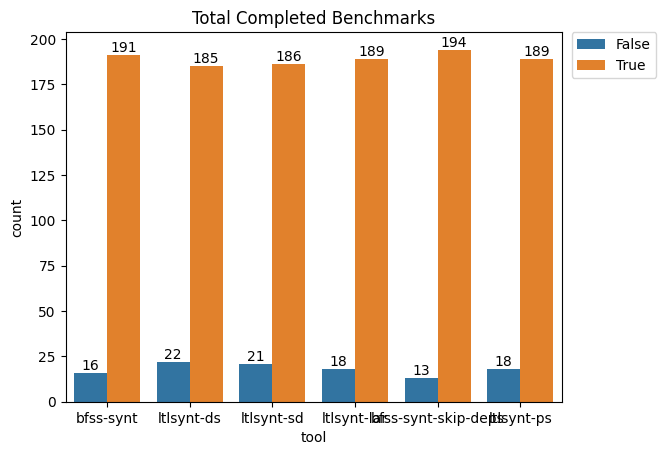

In [17]:
ax = sns.countplot(x="tool", data=benchmarks_df, hue="is_completed")
for container in ax.containers: ax.bar_label(container)
ax.set_title("Total Completed Benchmarks")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

### Benchmarks completed only by Bfss-Synt

In [18]:
# Unique Completed in BFSS-Synt:
_non_dep_tools = [tool for tool in tools_list if tool != "bfss-synt"]
unique_bfss_benchmarks = pivoted_benchmarks_df["is_completed"].copy()
unique_bfss_benchmarks["is_bfss_unique"] = unique_bfss_benchmarks.apply(
    lambda x: x["bfss-synt"] and not( any(x[tool] for tool in _non_dep_tools) )
, axis=1)
unique_bfss_benchmarks = pd.merge(
    unique_bfss_benchmarks[unique_bfss_benchmarks["is_bfss_unique"] == True],
    dependents_df,
    on='benchmark_name',
    how='left'
)
unique_bfss_benchmarks = pd.merge(
    unique_bfss_benchmarks,
    benchmark_metadata,
    on='benchmark_name'
)
unique_bfss_benchmarks

,benchmark_name,bfss-synt,bfss-synt-skip-deps,ltlsynt-ds,ltlsynt-lar,ltlsynt-ps,ltlsynt-sd,is_bfss_unique,dependent_vars_x,dependency_ratio_x,dependent_vars_y,dependency_ratio_y,is_realizable,input_vars,output_vars
0,LedMatrix,True,False,False,False,False,False,True,"[u0buffer2pin0buffer2pin, u0color0color, u0col...",0.407407,"[u0buffer2pin0buffer2pin, u0color0color, u0col...",0.407407,True,"p0p0eq0coordx0f1ddec0f1dsizex1b1b,p0p0on0write...","u0waitcounter0f1dinc0waitcounter1b,u0waitcount..."
1,ModdifiedLedMatrix5X,True,False,False,False,False,False,True,"[u0buffer2pin0buffer2pin, u0color0color, u0col...",0.400000,"[u0buffer2pin0buffer2pin, u0color0color, u0col...",0.400000,True,"p0eq0coordx0f1ddec0f1dsizex1b1b,p0on0write,p0e...",u0ramwrite0f1dwriteram0writecolor0xcoordinate0...


### Benchmarks wasn't completed by Bfss-Synt, but was copmleted by other tools

In [19]:
# Couldn't Completed by BFSS-Synt, but by other others:
bad_bfss_benchmarks = pivoted_benchmarks_df["is_completed"].copy()
bad_bfss_benchmarks["bfss_unique_fail"] = bad_bfss_benchmarks.apply(
    lambda x: not x["bfss-synt"] and any(x[tool] for tool in _non_dep_tools)
, axis=1)

bad_bfss_benchmarks = pd.merge(
    bad_bfss_benchmarks[bad_bfss_benchmarks["bfss_unique_fail"] == True],
    dependents_df,
    on='benchmark_name',
    how='left'
)
bad_bfss_benchmarks = pd.merge(
    bad_bfss_benchmarks,
    benchmark_metadata,
    on='benchmark_name',
    how='left'
)
bad_bfss_benchmarks

,benchmark_name,bfss-synt,bfss-synt-skip-deps,ltlsynt-ds,ltlsynt-lar,ltlsynt-ps,ltlsynt-sd,bfss_unique_fail,dependent_vars_x,dependency_ratio_x,dependent_vars_y,dependency_ratio_y,is_realizable,input_vars,output_vars
0,05,False,True,True,True,True,False,True,NaN,NaN,NaN,NaN,True,"x4,x3,x2,x1,x0","y4,y3,y2,y1,y0"
1,Automata16S,False,True,True,True,True,True,True,NaN,NaN,NaN,NaN,True,"p0b0wait,p0b0start","u0out0f1dnone1b,u0out0f1dconst91b,u0out0f1dcon..."
2,KitchenTimerV6,False,True,True,True,True,True,True,NaN,NaN,NaN,NaN,False,"p0p0eq0time0f1dzero1b,p0b0btn2start2stop,p0b0b...","u0time0f1dcountup0time0dt1b,u0time0f1dcountdow..."
3,KitchenTimerV7,False,True,True,True,True,True,True,NaN,NaN,NaN,NaN,False,"p0p0eq0time0f1dzero1b,p0b0btn2start2stop,p0b0b...","u0time0f1dcountup0time0dt1b,u0time0f1dcountdow..."
4,KitchenTimerV8,False,True,True,True,True,True,True,NaN,NaN,NaN,NaN,False,"p0p0eq0time0f1dzero1b,p0b0btn2start2stop,p0b0b...","u0time0f1dcountup0time0dt1b,u0time0f1dcountdow..."
5,lilydemo18,False,False,True,True,True,True,True,NaN,NaN,NaN,NaN,True,"i2,i1,i0","a3,a2,a1,a0"
